In [2]:
import numpy as np
import glob
import os
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

In [4]:
# **1. GPU 메모리 성장 설정 (가장 먼저 실행)**
physical_devices = tf.config.list_physical_devices('GPU')
for gpu in physical_devices:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
        print(f"메모리 성장 설정 완료: {gpu}")
    except RuntimeError as e:
        print(f"메모리 성장 설정 실패: {gpu} - {e}")

# **2. 분산 전략 설정**
# 분산 전략 설정: GPU 수에 따라 설정
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) >= 1:
    strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
    print(f'사용 중인 디바이스 수: {strategy.num_replicas_in_sync}')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'기본 전략 사용 중: {strategy.num_replicas_in_sync}')

메모리 성장 설정 완료: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
메모리 성장 설정 완료: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
메모리 성장 설정 완료: PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
사용 중인 디바이스 수: 2


In [5]:
# 메모리 매핑을 사용하여 데이터 로드
images = np.load('f_youtube_dataset_images.npy', mmap_mode='r')
landmarks = np.load('f_youtube_dataset_landmarks.npy', mmap_mode='r')

# limit개 샘플로 제한
limit = 100000
images_subset = images[:limit]
landmarks_subset = landmarks[:limit]

# 서브셋의 형태 출력
print(f'제한된 이미지 형태: {images_subset.shape}')         # 예: (limit, 224, 224, 3)
print(f'제한된 키포인트 형태: {landmarks_subset.shape}')   # 예: (limit, 68, 2)

제한된 이미지 형태: (100000, 224, 224, 3)
제한된 키포인트 형태: (100000, 68, 2)


### Only mouth

데이터셋 셔플, 배치, 프리페치 설정 완료.
배치 이미지 형태: (32, 224, 224, 3)
배치 입 랜드마크 형태: (32, 40)


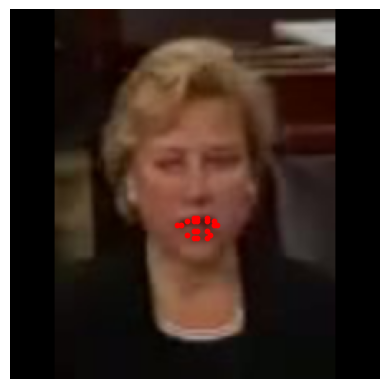

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 입술 외곽: 48번부터 59번 (총 12점)
# 입술 내곽: 60번부터 67번 (총 8점)

# 입 랜드마크 인덱스 정의 (0-based)
mouth_indices = np.arange(48, 68)  # 48번부터 67번까지

# 제너레이터 함수 정의 (입 랜드마크만 반환)
def data_generator(images, landmarks):
    num_samples = images.shape[0]
    indices = np.arange(num_samples)
    np.random.shuffle(indices)  # 샘플 섞기

    for idx in indices:
        image = images[idx].astype(np.float32) / 255.0  # 이미지 정규화 [0,1]
        landmark = landmarks[idx].astype(np.float32) / 224.0  # 키포인트 정규화 [0,1]
        landmark = landmark.reshape(-1, 2)  # (68, 2)
        mouth_landmarks = landmark[mouth_indices].reshape(-1)  # (20, 2) -> (40,)
        yield image, mouth_landmarks

def generator():
    return data_generator(images, landmarks)

# TensorFlow 데이터셋 생성 (입 랜드마크만 반환)
output_signature = (
    tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(40,), dtype=tf.float32)  # 20 keypoints * 2 (x, y) = 40
)

dataset = tf.data.Dataset.from_generator(
    generator,
    output_signature=output_signature
)

# 데이터셋 배치, 프리페치 설정
batch_size_per_replica = 16  # 각 GPU당 배치 사이즈
num_replicas = strategy.num_replicas_in_sync  # GPU 수
batch_size = batch_size_per_replica * num_replicas  

dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

print('데이터셋 셔플, 배치, 프리페치 설정 완료.')

# 데이터셋 형태 확인 및 시각화
for batch_images, batch_landmarks in dataset.take(1):
    print('배치 이미지 형태:', batch_images.shape)         
    print('배치 입 랜드마크 형태:', batch_landmarks.shape)   
    
    # 시각화 예시 (입 랜드마크만)
    image = batch_images[0].numpy()
    landmarks_plot = batch_landmarks[0].numpy() * 224.0  # 정규화된 키포인트를 원래 크기로 복원
    
    plt.imshow(image)
    plt.scatter(landmarks_plot[::2], landmarks_plot[1::2], c='r', s=10)
    plt.axis('off')
    plt.show()


In [7]:
# 분산 전략 내에서 모델 정의 및 컴파일
with strategy.scope():
    def create_model(input_shape=(224, 224, 3), num_keypoints=40):
        base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
        base_model.trainable = True

        x = base_model.output
        x = layers.BatchNormalization()(x)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(1024, activation='relu')(x)
        outputs = layers.Dense(num_keypoints, activation='sigmoid')(x)  # Sigmoid 활성화 함수 적용

        model = models.Model(inputs=base_model.input, outputs=outputs)
        return model

    # 모델 정의
    model = create_model()

    # 모델 컴파일
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='mean_squared_error',
                  metrics=['mae'])

    # 모델 요약
    model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [8]:
# 학습용과 검증용 데이터셋 분리
total_samples = 100000
train_ratio = 0.8
val_ratio = 0.2

train_size = int(train_ratio * total_samples)  
val_size = total_samples - train_size        

train_ds = dataset.take(train_size // batch_size)  
val_ds = dataset.skip(train_size // batch_size).take(val_size // batch_size)  

print(f'학습 데이터셋 배치 수: {train_size // batch_size}')  
print(f'검증 데이터셋 배치 수: {val_size // batch_size}')  


학습 데이터셋 배치 수: 2500
검증 데이터셋 배치 수: 625


In [9]:
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint, CSVLogger

# 콜백 설정
checkpoint = ModelCheckpoint('y_all_mouth_v2_adam_lr0001.h5', monitor='val_loss', save_best_only=True, verbose=1)
csv_logger = CSVLogger('y_all_mouth_training_log.csv', append=True)

# **모델 훈련**

EPOCHS = 100

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[checkpoint, csv_logger]
)

Epoch 1/100
INFO:tensorflow:Collective all_reduce tensors: 162 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 162 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2024-11-15 01:46:09.969861: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-11-15 01:46:10.029385: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-11-15 01:46:13.384265: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fca6a965550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-15 01:46:13.384309: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-11-15 01:46:13.384316: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-11-15 01:46:13.384322: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): Tesla T4, Compute Capability 7.5
2024-11-15 01:46:13.392444: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH

   2500/Unknown - 314s 106ms/step - loss: 6.5674e-04 - mae: 0.0164

2024-11-15 01:50:50.435632: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18292721877354504574
2024-11-15 01:50:50.435698: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9176334171116032298
2024-11-15 01:50:50.435712: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12705288280917875985
2024-11-15 01:50:50.435752: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 6375323124342513685
2024-11-15 01:50:50.435763: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 3750898155084891429
2024-11-15 01:50:50.435773: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10944064068028138466
2024-11-15 01:50:50.435786: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv 


Epoch 1: val_loss improved from inf to 0.00030, saving model to y_all_mouth_v2_adam_lr0001.h5


2024-11-15 01:52:04.229856: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2609184578852229834
2024-11-15 01:52:04.229913: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10944064068028138466
2024-11-15 01:52:04.229927: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11799392189447308606
2024-11-15 01:52:04.229952: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14881557929158476901
2024-11-15 01:52:04.230001: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9729870891088230045
2024-11-15 01:52:04.230009: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13728370395712165434
2024-11-15 01:52:04.230025: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv

2500/2500 [==============================] - 389s 136ms/step - loss: 6.5674e-04 - mae: 0.0164 - val_loss: 2.9647e-04 - val_mae: 0.0137
Epoch 2/100
2500/2500 [==============================] - ETA: 0s - loss: 1.0662e-04 - mae: 0.0078
Epoch 2: val_loss improved from 0.00030 to 0.00010, saving model to y_all_mouth_v2_adam_lr0001.h5
2500/2500 [==============================] - 333s 133ms/step - loss: 1.0662e-04 - mae: 0.0078 - val_loss: 1.0039e-04 - val_mae: 0.0077
Epoch 3/100
2500/2500 [==============================] - ETA: 0s - loss: 6.5752e-05 - mae: 0.0061
Epoch 3: val_loss did not improve from 0.00010
2500/2500 [==============================] - 333s 133ms/step - loss: 6.5752e-05 - mae: 0.0061 - val_loss: 2.0214e-04 - val_mae: 0.0114
Epoch 4/100
2500/2500 [==============================] - ETA: 0s - loss: 5.6012e-05 - mae: 0.0056
Epoch 4: val_loss improved from 0.00010 to 0.00006, saving model to y_all_mouth_v2_adam_lr0001.h5
2500/2500 [==============================] - 331s 132ms/st

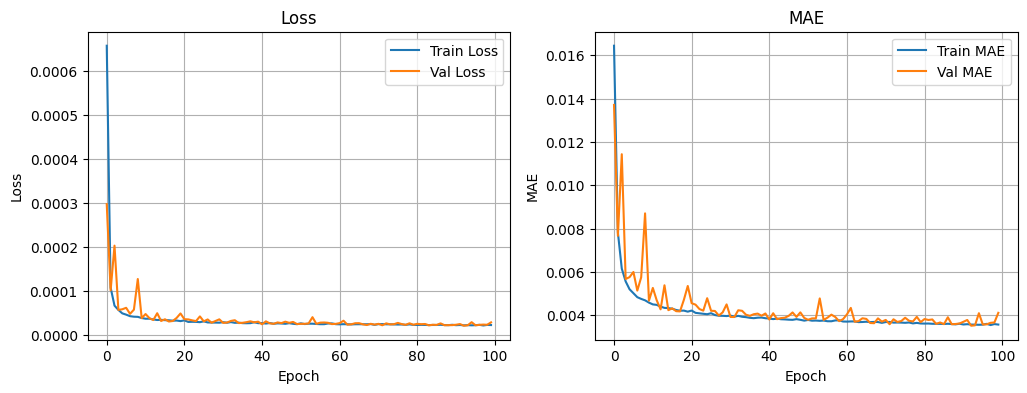

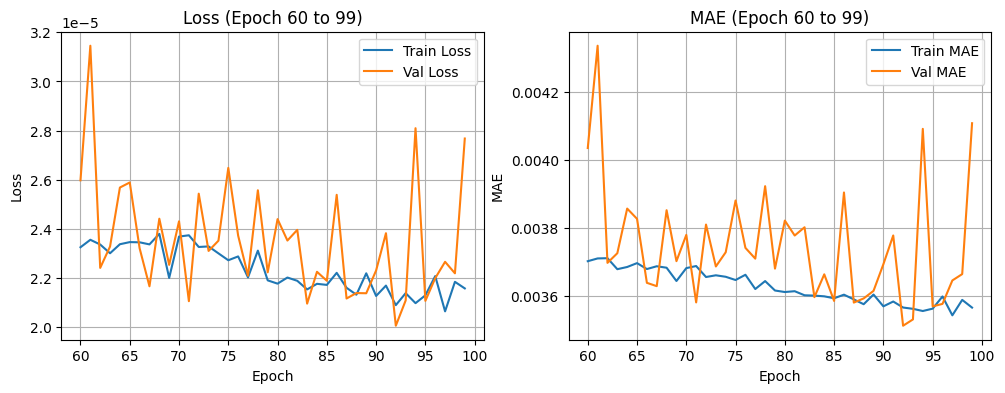

Best Epoch: 93
Minimum Validation Loss: 2.0056379071320407e-05


In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 경로 설정
csv_file_path = 'csv_logger/y_all_mouth_training_log.csv'

# CSV 파일 읽기
history_df = pd.read_csv(csv_file_path)

# 에포크 수 가져오기
epochs = history_df['epoch']

# 전체 에포크 그래프 그리기
plt.figure(figsize=(12, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, history_df['loss'], label='Train Loss')
plt.plot(epochs, history_df['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# MAE 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, history_df['mae'], label='Train MAE')
plt.plot(epochs, history_df['val_mae'], label='Val MAE')
plt.legend()
plt.title('MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid(True)

plt.show()

# 특정 에포크 범위 설정
start_epoch = 60  # 시작 에포크 (0부터 시작)
end_epoch = 100   # 끝 에포크 (포함하지 않음)

# 에포크 범위에 해당하는 인덱스 생성
epoch_range = (history_df['epoch'] >= start_epoch) & (history_df['epoch'] < end_epoch)

# 선택한 에포크 범위의 데이터 선택
selected_epochs = history_df['epoch'][epoch_range]
train_loss = history_df['loss'][epoch_range]
val_loss = history_df['val_loss'][epoch_range]
train_mae = history_df['mae'][epoch_range]
val_mae = history_df['val_mae'][epoch_range]

# 선택한 에포크 범위 그래프 그리기
plt.figure(figsize=(12, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(selected_epochs, train_loss, label='Train Loss')
plt.plot(selected_epochs, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss (Epoch {} to {})'.format(start_epoch, end_epoch - 1))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# MAE 그래프
plt.subplot(1, 2, 2)
plt.plot(selected_epochs, train_mae, label='Train MAE')
plt.plot(selected_epochs, val_mae, label='Val MAE')
plt.legend()
plt.title('MAE (Epoch {} to {})'.format(start_epoch, end_epoch - 1))
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid(True)

plt.show()

min_val_loss = history_df['val_loss'].min()
best_epoch = history_df[history_df['val_loss'] == min_val_loss]['epoch'].values[0] + 1  # 1을 더해줍니다.
print(f"Best Epoch: {best_epoch}")
print(f"Minimum Validation Loss: {min_val_loss}")

In [13]:
def evaluate_multiple_images(model, images, keypoints, target_size=224, thresholds=[1, 3, 5, 7, 10], num_samples=100):
    """
    여러 이미지에 대해 모델의 성능을 평가하는 함수.

    Parameters:
        model (tf.keras.Model): 사전 학습된 모델.
        images (np.ndarray): 평가할 이미지들 (형태: (num_samples, 224, 224, 3)).
        keypoints (np.ndarray): 실제 키포인트들 (형태: (num_samples, 40)).
        target_size (int): 모델의 입력 이미지 크기.
        thresholds (list): 거리 임계값들의 리스트 (픽셀 단위).
        num_samples (int): 평가할 샘플 수.
    """
    pck_values = {th: [] for th in thresholds}
    mse_list = []
    mae_list = []

    for i in range(num_samples):
        image = images[i]
        true_keypoint = keypoints[i].reshape(-1) / 224.0  # [0, 1]로 정규화

        # 이미지 전처리
        input_image, scale, pad_left, pad_top = preprocess_frame(image, target_size=target_size)

        # 모델 예측
        try:
            predicted_keypoint = model.predict(input_image)[0]  # 예: (40,)
        except Exception as e:
            print(f"[예측 오류] 샘플 {i}의 키포인트 예측 실패: {e}")
            continue

        # 키포인트 배열이 [x1, y1, x2, y2, ..., x20, y20] 형식인지 확인
        if predicted_keypoint.shape[0] != 40:
            print(f"[예측 오류] 샘플 {i}의 키포인트 길이가 예상과 다릅니다: {predicted_keypoint.shape[0]}")
            continue

        # 키포인트를 (20, 2) 형태로 리쉐이프
        predicted_keypoint = predicted_keypoint.reshape(-1, 2)

        # 키포인트를 [0, 224] 범위로 변환
        predicted_keypoint = predicted_keypoint * target_size  # target_size = 224

        # 키포인트를 원본 이미지 크기로 복원
        predicted_keypoint[:, 0] = (predicted_keypoint[:, 0] - pad_left) / scale
        predicted_keypoint[:, 1] = (predicted_keypoint[:, 1] - pad_top) / scale

        # 실제 키포인트도 [0, 224] 범위로 변환
        true_keypoint = true_keypoint * target_size
        true_keypoint = true_keypoint.reshape(-1, 2)

        # MSE 및 MAE 계산
        mse = mean_squared_error(true_keypoint, predicted_keypoint)
        mae = mean_absolute_error(true_keypoint, predicted_keypoint)
        mse_list.append(mse)
        mae_list.append(mae)

        # PCK 계산
        distances = np.linalg.norm(true_keypoint - predicted_keypoint, axis=1)
        for threshold in thresholds:
            num_correct_keypoints = np.sum(distances <= threshold)
            pck = num_correct_keypoints / len(distances)
            pck_values[threshold].append(pck)

    # 평균 지표 계산
    avg_mse = np.mean(mse_list)
    avg_mae = np.mean(mae_list)
    print(f"평균 MSE: {avg_mse:.4f}")
    print(f"평균 MAE: {avg_mae:.4f}")

    for threshold in thresholds:
        avg_pck = np.mean(pck_values[threshold])
        print(f"평균 PCK@{threshold}px: {avg_pck:.4f}")

# 함수 호출
evaluate_multiple_images(
    loaded_model,
    test_images,
    test_landmarks,
    target_size=224,
    thresholds=[1, 3, 5, 7, 10],
    num_samples=100  # 평가할 샘플 수
)

NameError: name 'loaded_model' is not defined